### Read OISST v2 data via Thredds and test the marineHeatWaves algorithm

In [1]:
# Load required modules
import numpy as np
from datetime import date
from matplotlib import pyplot as plt
import xarray as xr
# Load marineHeatWaves definition module
import marineHeatWaves as mhw

In [2]:
base_url = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/'
files = [f'{base_url}sst.day.mean.{year}.v2.nc' for year in range(1981, 2021)]
files
#https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1984.v2.nc.html

['https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1981.v2.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1982.v2.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1983.v2.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1984.v2.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1985.v2.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1986.v2.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1987.v2.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1988.v2.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1989.v2.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1990.v2.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.

In [3]:
%%time
data = xr.open_mfdataset(files)

CPU times: user 449 ms, sys: 44.6 ms, total: 494 ms
Wall time: 2.84 s


### Marine Heatwave Detection
The marineHeatWaves (mhw) module consists of a number of functions for the detection and characterization of MHWs. The main function is the detection function (detect) which takes as input a time series of temperature (and a corresponding time vector) and outputs a set of detected MHWs.

#### Case study #1: 2011 Western Australia event
As an example, let's load a daily time series of SST off Western Australia (WA; 112.5 ∘ E, 29.5 ∘ S) over the 1982 to 2014 period, remotely-sensed from the AVHRR satellite platform:

### Let's look at the point for case 1 in a map

In [ ]:
%matplotlib inline
dummy = data.sst.sel(lon = 112.5, lat = -29.5, method='nearest')[0]
fig, ax = plt.subplots(1,1)
data.sst[-1,:].plot(ax=ax, vmin=-2,vmax=32)
ax.plot(dummy.lon.values, dummy.lat.values, color='r', ms=5,marker='o')
ax.set_xlim(100,130)
ax.set_ylim(-40,-22);

Looks good! We can now extract a time series for SST at this point.

In [18]:
%%time
wa_ds = data.sst.sel(lon = 112.5, lat = -29.5, 
             method='nearest').sel(time = slice("1982-01-01","2014-12-31")).load()

CPU times: user 389 ms, sys: 66.9 ms, total: 456 ms
Wall time: 5min 34s


In [19]:
wa_ds.to_netcdf('wa_ds.nc')

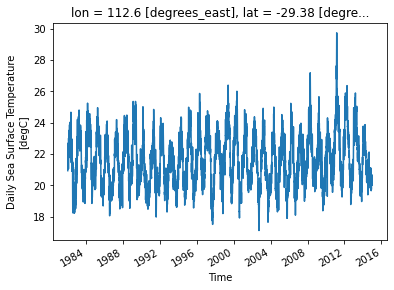

In [20]:
wa_ds.plot()

Next we run the MHW detection algorithm which returns the variable mhws, consisting of the detected MHWs, and clim, consisting of the climatological (varying by day-of-year) seasonal cycle and extremes threshold:

In [56]:
# Generate time vector using datetime format (January 1 of year 1 is day 1)
t = np.arange(date(1982,1,1).toordinal(),date(2014,12,31).toordinal()+1)
dates = [date.fromordinal(tt.astype(int)) for tt in t]

In [24]:
mhws_case1, clim_case1 = mhw.detect(t, wa_ds.values)

This algorithm has detected the following number of MHW events:

In [26]:
mhws_case1['n_events']

60

The first ten events, for example, have the following maximum intensities (in C)  

In [27]:
mhws_case1['intensity_max'][0:10]

[1.9759563938263902,
 2.1255383645334582,
 2.241348082019435,
 1.2863466816563793,
 1.8312707716418863,
 1.5018472363871922,
 2.2082389708488286,
 1.1157563117242653,
 1.690619499452648,
 1.9938329881237422]

Let's have a look at some properties of the event with the largest maximum intensity

In [29]:
ev = np.argmax(mhws_case1['intensity_max']) # Find largest event
print ('Maximum intensity:', mhws_case1['intensity_max'][ev], 'deg. C')
print ('Average intensity:', mhws_case1['intensity_mean'][ev], 'deg. C')
print ('Cumulative intensity:', mhws_case1['intensity_cumulative'][ev], 'deg. C-days')
print ('Duration:', mhws_case1['duration'][ev], 'days')
print ('Start date:', mhws_case1['date_start'][ev].strftime("%d %B %Y"))
print ('End date:', mhws_case1['date_end'][ev].strftime("%d %B %Y"))

Maximum intensity: 6.483709366090839 deg. C
Average intensity: 3.1762778888865806 deg. C
Cumulative intensity: 193.7529512220814 deg. C-days
Duration: 61 days
Start date: 06 February 2011
End date: 07 April 2011


This turns out to be the infamous 2011 MHW off WA. Let's plot the SST time series over the full record and also have a closer look at the identified MHW event:

Text(0, 0.5, 'SST [$^\\circ$C]')

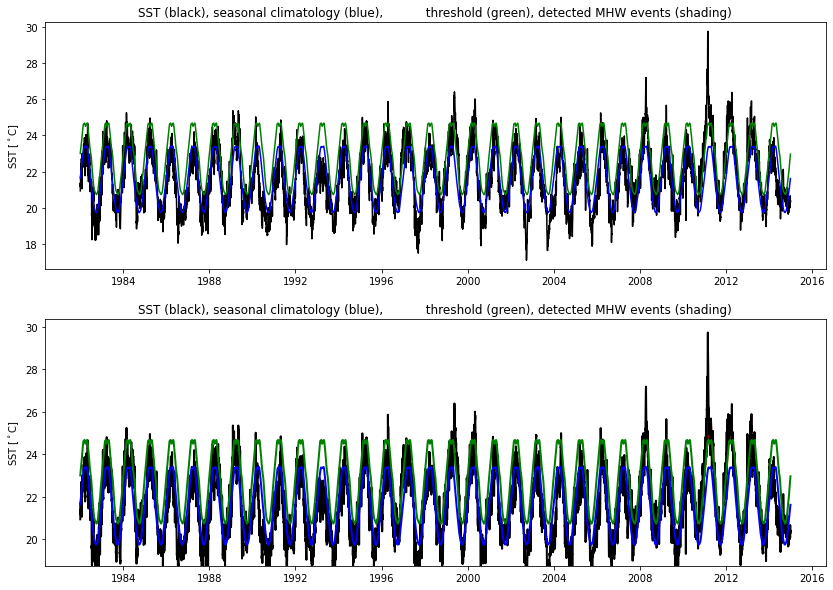

In [37]:
plt.figure(figsize=(14,10))
plt.subplot(2,1,1)
# Plot SST, seasonal cycle, and threshold
plt.plot(dates, wa_ds.values, 'k-')
plt.plot(dates, clim_case1['thresh'], 'g-')
plt.plot(dates, clim_case1['seas'], 'b-')
plt.title('SST (black), seasonal climatology (blue), \
          threshold (green), detected MHW events (shading)')
#plt.xlim(t[0], t[-1])
plt.ylim(wa_ds.min()-0.5, wa_ds.max()+0.5)
plt.ylabel(r'SST [$^\circ$C]')
plt.subplot(2,1,2)
# Find indices for all ten MHWs before and after event of interest and shade accordingly
for ev0 in np.arange(ev-10, ev+11, 1):
    t1 = np.where(t==mhws_case1['time_start'][ev0])[0][0]
    t2 = np.where(t==mhws_case1['time_end'][ev0])[0][0]
    plt.fill_between(dates[t1:t2+1], wa_ds[t1:t2+1], clim_case1['thresh'][t1:t2+1], \
                     color=(1,0.6,0.5))
# Find indices for MHW of interest (2011 WA event) and shade accordingly
t1 = np.where(t==mhws_case1['time_start'][ev])[0][0]
t2 = np.where(t==mhws_case1['time_end'][ev])[0][0]
plt.fill_between(dates[t1:t2+1], wa_ds[t1:t2+1], clim_case1['thresh'][t1:t2+1], \
                 color='r')
# Plot SST, seasonal cycle, threshold, shade MHWs with main event in red
plt.plot(dates, wa_ds, 'k-', linewidth=2)
plt.plot(dates, clim_case1['thresh'], 'g-', linewidth=2)
plt.plot(dates, clim_case1['seas'], 'b-', linewidth=2)
plt.title('SST (black), seasonal climatology (blue), \
          threshold (green), detected MHW events (shading)')
#plt.xlim(mhws['time_start'][ev]-150, mhws['time_end'][ev]+150)
plt.ylim(clim_case1['seas'].min() - 1, clim_case1['seas'].max() + mhws_case1['intensity_max'][ev] + 0.5)
plt.ylabel(r'SST [$^\circ$C]')

In [43]:
len(mhws['category'])

60

### Case study \#2: 2012 Northwest Atlantic event

We can also have a look at the 2012 Northwest Atlantic (NWA) event. Let's load a daily time series of SST from the NWA (67 ∘ W, 43 ∘ N) from the same data set as above and repeat the analysis:



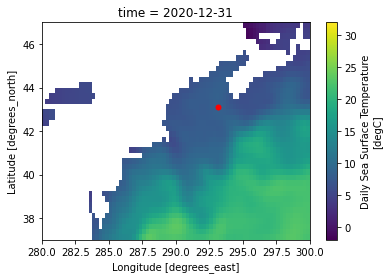

In [49]:
fig, ax = plt.subplots(1,1)
dummy = data.sst.sel(lon = 293., lat =43., method='nearest')[0]
data.sst[-1,:].plot(ax=ax, vmin=-2,vmax=32)
ax.plot(dummy.lon.values, dummy.lat.values, color='r', ms=5,marker='o')
ax.set_ylim(37,47)
ax.set_xlim(280,300);

In [53]:
%%time
nwa_ds = data.sst.sel(lon = 293., lat = 43., 
             method='nearest').sel(time = slice("1982-01-01","2014-12-31")).load()

CPU times: user 260 ms, sys: 38.1 ms, total: 298 ms
Wall time: 5min 50s


In [54]:
nwa_ds.to_netcdf('nwa_ds.nc')

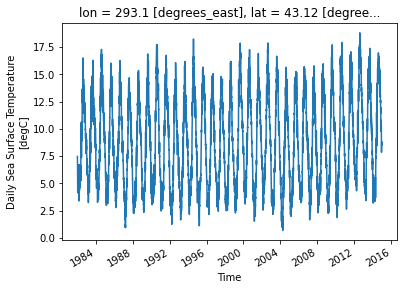

In [55]:
nwa_ds.plot()

In [60]:
# Detect MHW events
mhws_case2, clim_case2 = mhw.detect(t, nwa_ds.values)

In [86]:
mhws_case2.keys()

dict_keys(['time_start', 'time_end', 'time_peak', 'date_start', 'date_end', 'date_peak', 'index_start', 'index_end', 'index_peak', 'duration', 'duration_moderate', 'duration_strong', 'duration_severe', 'duration_extreme', 'intensity_max', 'intensity_mean', 'intensity_var', 'intensity_cumulative', 'intensity_max_relThresh', 'intensity_mean_relThresh', 'intensity_var_relThresh', 'intensity_cumulative_relThresh', 'intensity_max_abs', 'intensity_mean_abs', 'intensity_var_abs', 'intensity_cumulative_abs', 'category', 'rate_onset', 'rate_decline', 'n_events'])

In [89]:
mhws_case2['category']

['Moderate',
 'Moderate',
 'Moderate',
 'Moderate',
 'Moderate',
 'Moderate',
 'Moderate',
 'Strong',
 'Moderate',
 'Moderate',
 'Moderate',
 'Moderate',
 'Moderate',
 'Moderate',
 'Strong',
 'Moderate',
 'Moderate',
 'Moderate',
 'Moderate',
 'Moderate',
 'Moderate',
 'Moderate',
 'Moderate',
 'Moderate',
 'Moderate',
 'Moderate',
 'Strong',
 'Moderate',
 'Moderate',
 'Moderate',
 'Strong',
 'Strong',
 'Moderate',
 'Strong',
 'Strong',
 'Strong',
 'Strong',
 'Moderate',
 'Strong',
 'Moderate',
 'Moderate',
 'Moderate',
 'Moderate',
 'Moderate',
 'Moderate',
 'Moderate',
 'Strong',
 'Moderate',
 'Moderate']

In [92]:
clim_case2['seas']

array([6.41527364, 6.34090059, 6.26747927, ..., 6.64348925, 6.56630982,
       6.4903674 ])

In [62]:
# Find largest event
ev = np.argmax(mhws_case2['intensity_max'])
print ('Maximum intensity:', mhws_case2['intensity_max'][ev], 'deg. C')
print ('Average intensity:', mhws_case2['intensity_mean'][ev], 'deg. C')
print ('Cumulative intensity:', mhws_case2['intensity_cumulative'][ev], 'deg. C-days')
print ('Duration:', mhws_case2['duration'][ev], 'days')
print ('Start date:', mhws_case2['date_start'][ev].strftime("%d %B %Y"))
print ('End date:', mhws_case2['date_end'][ev].strftime("%d %B %Y"))

Maximum intensity: 4.758620846656061 deg. C
Average intensity: 2.550958615970375 deg. C
Cumulative intensity: 132.6498480304595 deg. C-days
Duration: 52 days
Start date: 10 April 2012
End date: 31 May 2012


Again, the event with largest maximum intensity turns out to be an event known in the literature: the 2012 NWA event. Let's plot it as above:

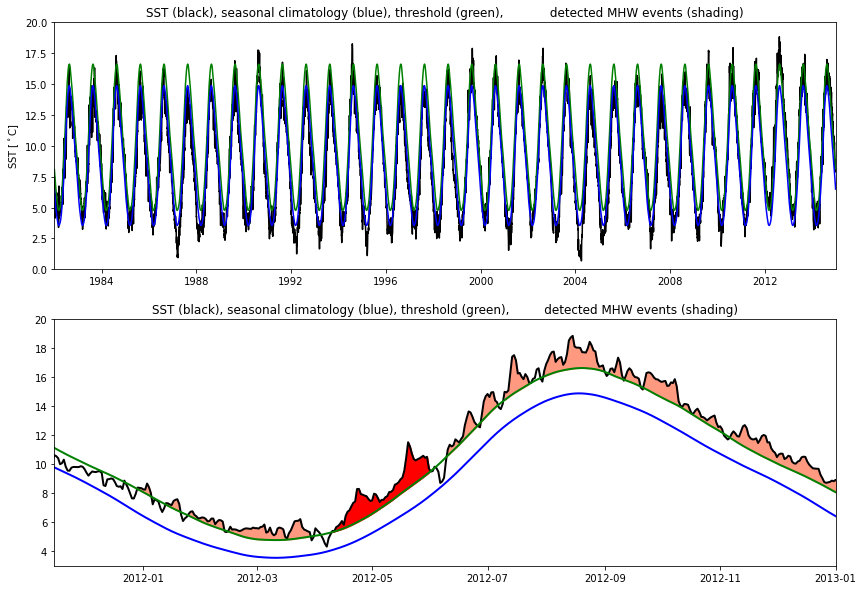

In [81]:
plt.figure(figsize=(14,10))
plt.subplot(2,1,1)
# Plot SST, seasonal cycle, and threshold
plt.plot(dates, nwa_ds, 'k-')
plt.plot(dates, clim_case2['thresh'], 'g-')
plt.plot(dates, clim_case2['seas'], 'b-')
plt.title('SST (black), seasonal climatology (blue), threshold (green), \
           detected MHW events (shading)')
plt.ylim(nwa_ds.min()-0.5, nwa_ds.max()+0.5)
plt.ylabel(r'SST [$^\circ$C]')
plt.xlim(dates[0],dates[-1])
plt.ylim(0,20);

# second plot
plt.subplot(2,1,2)
# Find indices for all ten MHWs before and after event of interest and shade accordingly
for ev0 in np.arange(ev-10, ev+11, 1):
    t1 = np.where(t==mhws_case2['time_start'][ev0])[0][0]
    t2 = np.where(t==mhws_case2['time_end'][ev0])[0][0]
    plt.fill_between(dates[t1:t2+1], nwa_ds[t1:t2+1], clim_case2['thresh'][t1:t2+1], \
                     color=(1,0.6,0.5))
# Find indices for MHW of interest (2012 NWA event) and shade accordingly
t1 = np.where(t==mhws_case2['time_start'][ev])[0][0]
t2 = np.where(t==mhws_case2['time_end'][ev])[0][0]
plt.fill_between(dates[t1:t2+1], nwa_ds[t1:t2+1], clim_case2['thresh'][t1:t2+1], color='r')
# Plot SST, seasonal cycle, threshold, shade MHWs with main event in red
plt.plot(dates, nwa_ds, 'k-', linewidth=2)
plt.plot(dates, clim_case2['thresh'], 'g-', linewidth=2)
plt.plot(dates, clim_case2['seas'], 'b-', linewidth=2)
plt.title('SST (black), seasonal climatology (blue), threshold (green), \
        detected MHW events (shading)')
plt.xlim('2011, 11, 15','2013, 1, 1')
plt.ylim(3,20);

Interestingly, the 2012 NWA event doesn't appear to be as intense as the 2011 WA event. That is partly because it occured outside the summer months. It is nonetheless the largest event on record according to maximum intensity:

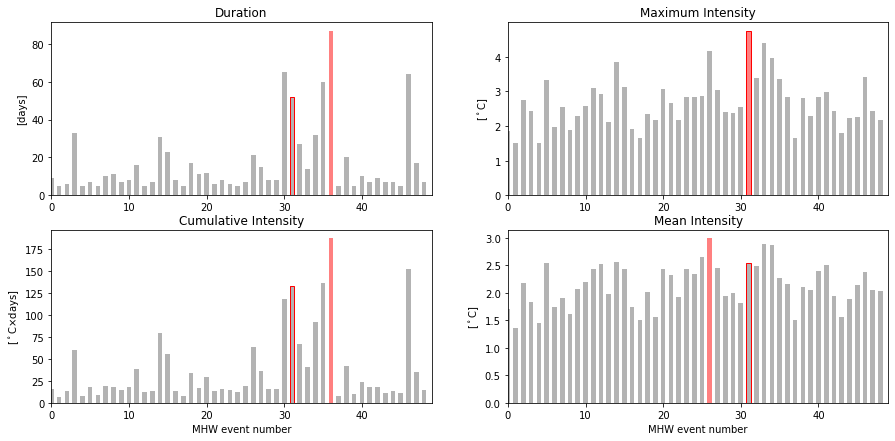

In [83]:
plt.figure(figsize=(15,7))
# Duration
plt.subplot(2,2,1)
evMax = np.argmax(mhws_case2['duration'])
plt.bar(range(mhws_case2['n_events']), mhws_case2['duration'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws_case2['duration'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws_case2['duration'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws_case2['n_events'])
plt.ylabel('[days]')
plt.title('Duration')
# Maximum intensity
plt.subplot(2,2,2)
evMax = np.argmax(mhws_case2['intensity_max'])
plt.bar(range(mhws_case2['n_events']), mhws_case2['intensity_max'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws_case2['intensity_max'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws_case2['intensity_max'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws_case2['n_events'])
plt.ylabel(r'[$^\circ$C]')
plt.title('Maximum Intensity')
# Mean intensity
plt.subplot(2,2,4)
evMax = np.argmax(mhws_case2['intensity_mean'])
plt.bar(range(mhws_case2['n_events']), mhws_case2['intensity_mean'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws_case2['intensity_mean'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws_case2['intensity_mean'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws_case2['n_events'])
plt.title('Mean Intensity')
plt.ylabel(r'[$^\circ$C]')
plt.xlabel('MHW event number')
# Cumulative intensity
plt.subplot(2,2,3)
evMax = np.argmax(mhws_case2['intensity_cumulative'])
plt.bar(range(mhws_case2['n_events']), mhws_case2['intensity_cumulative'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws_case2['intensity_cumulative'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws_case2['intensity_cumulative'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws_case2['n_events'])
plt.title(r'Cumulative Intensity')
plt.ylabel(r'[$^\circ$C$\times$days]')
plt.xlabel('MHW event number');

However, the 2012 NWA event (red outlined bars) is not the highest ranked event (red shaded bars) when sorted according to mean intensity, cumulative intenstiy and duration:

In [96]:
#mhws_case2.rank

In [ ]:
rank, returnPeriod = mhw.rank(t, mhws)
print ("The 2012 NWA event is ranked number " \
        + str(rank['duration'][ev]) + " by duration")
print ("The 2012 NWA event is ranked number " \
        + str(rank['intensity_max'][ev]) + " by maximum intensity")
print ("The 2012 NWA event is ranked number " \
        + str(rank['intensity_mean'][ev]) + " by mean intensity")
print ("The 2012 NWA event is ranked number " \
        + str(rank['intensity_cumulative'][ev]) + " by cumulative intensity")